In [61]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [62]:
def parse_filename(filename):
    fn_re = "pool-(?P<pool>.+)_expr-(?P<expr>.+)_sw-(?P<sw>\d+)"
    fn_re = fn_re + "_es-(?P<es>\d+)_qd-(?P<qd>\d+)_pg-(?P<pg>\d+)"
    fn_re = fn_re + "_rt-(?P<rt>\d+)_if-(?P<if>.+)\.log"
    fn_re = re.compile(fn_re)
    match = fn_re.match(os.path.basename(filename))
    assert match
    return match

In [63]:
def short_ename(ename):
    mapping = {
        'bytestream_n1_write': 'n1wr',
        'bytestream_n1_append': 'n1ap',
        'bytestream_11': '11wr',
        'map_n1': 'n1kv',
        'map_11': '11kv',
        
        'bytestream_n1_read': 'n1rd',
        'bytestream_11_read': '11rd',
        'map_n1_read': 'n1kvrd',
        'map_11_read': '11kvrd'
    }
    return mapping.get(ename, ename)

In [64]:
def read_trace(filename, trimFrontSec=30, trimBackSec=30):
    ### read up raw throughput file
    trace = pd.read_table(filename, sep=" ",
        header=None, names=("completed", "throughput"))
    
    ### shift timeseries to have zero start time
    trace.completed = pd.to_datetime(trace.completed, unit="ns")
    trace.completed = trace.completed - min(trace.completed)
    trace.completed = trace.completed / pd.Timedelta(seconds=1)
    
    ### trim front and back of trace
    trace = trace[(trace.completed > trimFrontSec) & (trace.completed <
        max(trace.completed) - trimBackSec)]
    trace.completed = trace.completed - min(trace.completed)
    
    ### order like a time series by the completion time of the I/O
    trace.sort_values(by='completed', ascending=True, inplace=True)
    return trace

In [83]:
def plot_throughput_trace(trace, filename, ax):
    trace.throughput = pd.rolling_mean(trace.throughput, window=5, min_periods=1)
    md = parse_filename(filename)
    label = md.group('expr')
    label = short_ename(label)
    #if 'es-128' in filename:
    #    label = label + " 128b"
    #elif 'es-1024' in filename:
    #    label = label + " 1KB"
    #elif 'es-4096' in filename:
    #    label = label + " 4KB"
    ax.plot(trace.completed, trace.throughput, label=label,)
    #print label, trace.throughput.mean()
    #ax.set_title('Single OSD Throughput (Jewel 2016)')
    #ax.set_ylabel('Appends per Second per OSD')
    ax.set_xlabel('Time (Sec)')

In [84]:
def plot_traces(traces, fn, finish=True, useAx=None):
    if useAx:
        ax = useAx
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    for filename in traces:
        trace_data = read_trace(filename)
        md = parse_filename(filename)
        #plot_throughput_trace(trace_data, md, ax)
        plot_throughput_trace(trace_data, filename, ax)
    if finish:
        lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(fn + '.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
    else:
        return ax

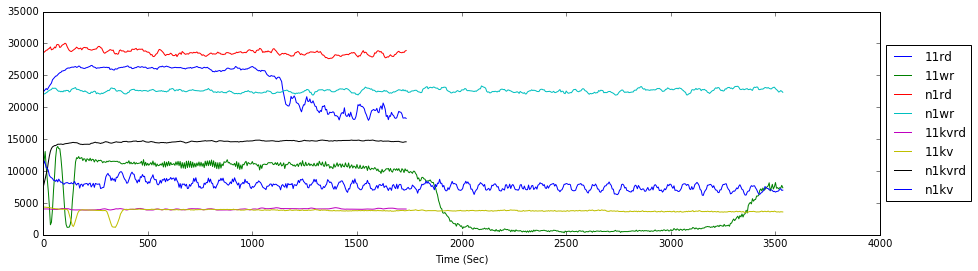

In [85]:
traces = glob.glob('results.pd.basic_cls_rand_read.node0.04-26-2016_13-54-07/*.log')
plot_traces(list(traces), 'output.read.30min')

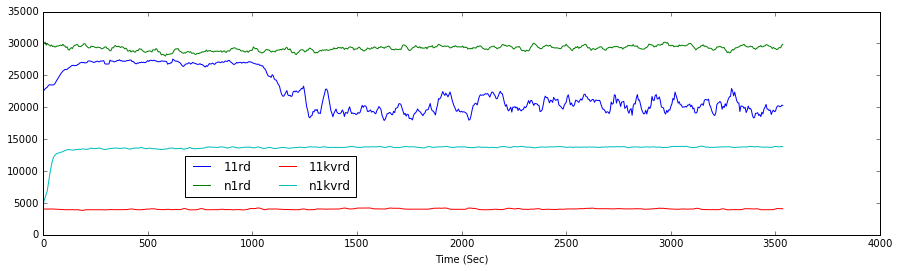

In [86]:
read_traces = glob.glob('results.pd.basic_cls_rand_read.node0.04-26-2016_20-43-54/*read*.log')
ax = plot_traces(list(read_traces), 'output.read.60min', finish=False)
lgd = ax.legend(loc='best', ncol=2, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
plt.savefig('output.read.60min.1k.png', dpi=300, bbox_inches='tight')

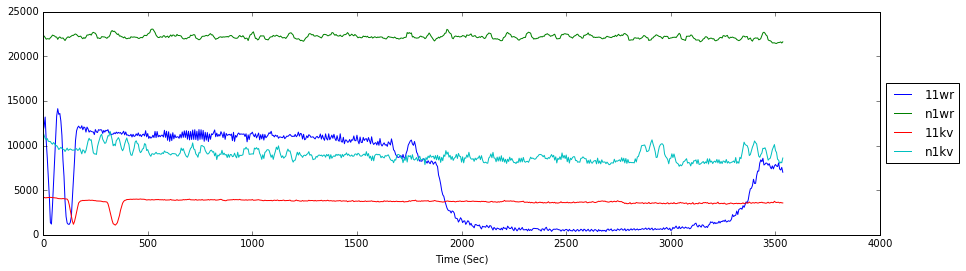

In [87]:
write_traces = [fn for fn in glob.glob('results.pd.basic_cls_rand_read.node0.04-26-2016_20-43-54/*.log')
                if not fn in read_traces]
plot_traces(list(write_traces), 'output.write.60min')

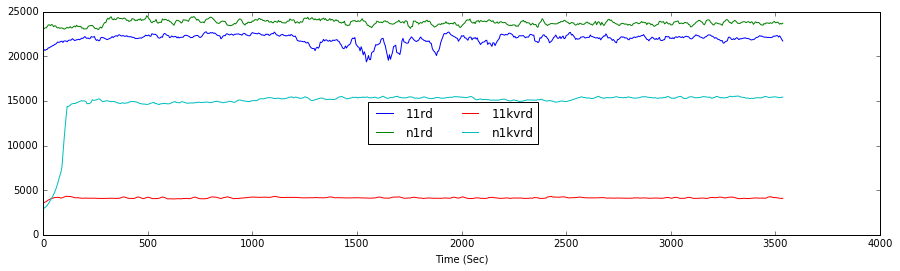

In [88]:
read_traces = glob.glob('results.pd.basic_cls_rand_read.node0.05-02-2016_11-06-15/*read*.log')
ax = plot_traces(list(read_traces), 'output.read.60min', finish=False)
lgd = ax.legend(loc='best', ncol=2, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
plt.savefig('output.read.60min.png', dpi=300, bbox_inches='tight')

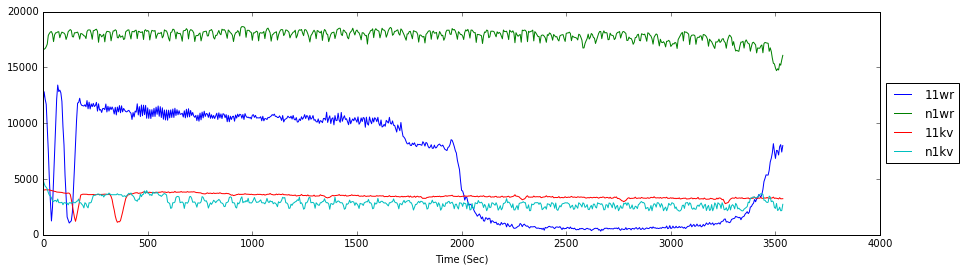

In [89]:
write_traces = [fn for fn in glob.glob('results.pd.basic_cls_rand_read.node0.05-02-2016_11-06-15/*.log')
                if not fn in read_traces]
plot_traces(list(write_traces), 'output.write.60min')

In [90]:
def plot_read_write(filenames, name):
    read_traces = filter(lambda fn: '_read_sw' in fn, filenames)
    ax = plot_traces(list(read_traces), name, finish=False)
    lgd = ax.legend(loc='best', ncol=2)#, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
    plt.savefig('%s_reads.png' % name, dpi=300, bbox_inches='tight')
    
    write_traces = filter(lambda fn: fn not in read_traces, filenames)
    ax = plot_traces(list(write_traces), '%s_writes.png' % name, finish=False)
    lgd = ax.legend(loc='best', ncol=2)
    plt.savefig('%s_writes.png' % name, dpi=300, bbox_inches='tight')

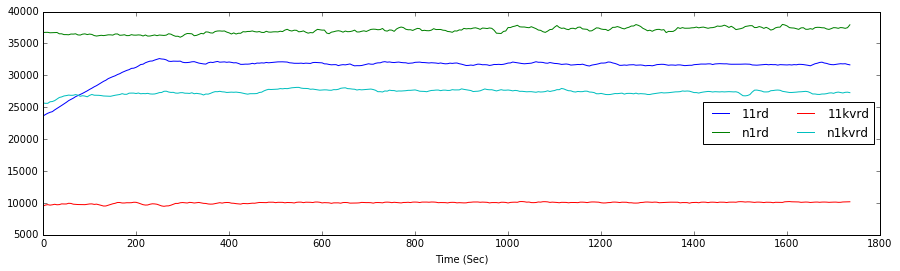

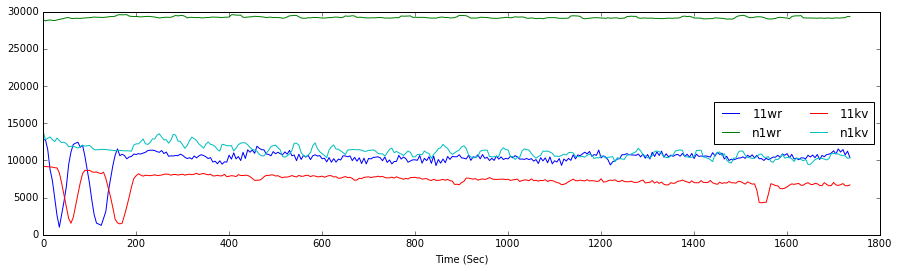

In [91]:
plot_read_write(glob.glob('results.pd.librados_read_data_nvme.pl1.05-20-2016_03-36-34/*.log'), 'data_nvm')

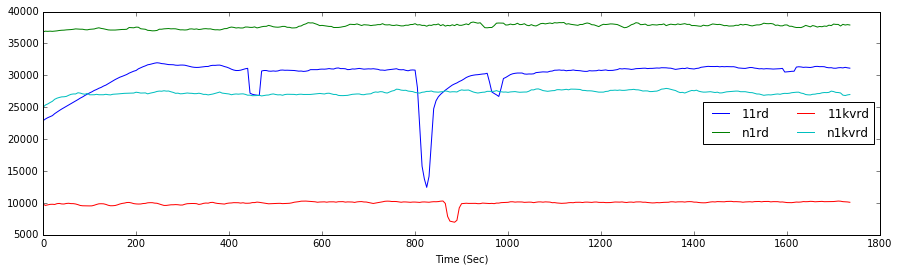

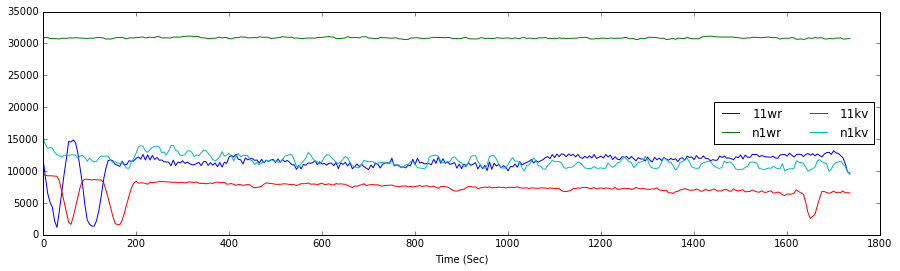

In [92]:
plot_read_write(glob.glob('results.pd.librados_read_data_jrnl_nvme.pl1.05-19-2016_23-19-40/*.log'), 'data_jrnl_nvm')

In [106]:
def plot_sub_sweep(ax, ver, iodir, conf, esize):
    dirfilter = '*librados_%s_%s_%s.node0*/*.log' % (ver, conf, esize)
    allfiles = sorted(glob.glob(dirfilter))
    readfiles = filter(lambda fn: '_read_' in fn, allfiles)
    if iodir == 'read':
        traces = readfiles
    else:
        traces = [fn for fn in allfiles if fn not in readfiles]
    plot_traces(list(traces), 'a', finish=False, useAx=ax)
    lgd = ax.legend(loc='best', ncol=2)#, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
    #plt.savefig('%s_reads.png' % name, dpi=300, bbox_inches='tight')
    
def plot_sweep(ver, iodir):
    plt.rcParams['figure.figsize'] = 15,4
    f1, axs1 = plt.subplots(1, 3, sharex=True, sharey=True)
    
    plot_sub_sweep(axs1[0], ver, iodir, 'ssd', 'small')
    plot_sub_sweep(axs1[1], ver, iodir, 'ssd', 'med')
    plot_sub_sweep(axs1[2], ver, iodir, 'ssd', 'large')
    axs1[0].set_ylabel('SSD')
    
    f2, axs2 = plt.subplots(1, 3, sharex=True, sharey=True)
    plot_sub_sweep(axs2[0], ver, iodir, 'hdd', 'small')
    plot_sub_sweep(axs2[1], ver, iodir, 'hdd', 'med')
    plot_sub_sweep(axs2[2], ver, iodir, 'hdd', 'large')
    axs2[0].set_ylabel('HDD')
    
    f3, axs3 = plt.subplots(1, 3, sharex=True, sharey=True)
    plot_sub_sweep(axs3[0], ver, iodir, 'ssd_hdd', 'small')
    plot_sub_sweep(axs3[1], ver, iodir, 'ssd_hdd', 'med')
    plot_sub_sweep(axs3[2], ver, iodir, 'ssd_hdd', 'large')
    axs3[0].set_ylabel('SSD+HDD')
    
    for axs in [axs1, axs2, axs3]:
        axs[0].set_title('512b Entry')
        axs[1].set_title('1K Entry')
        axs[2].set_title('4K Entry')
    
    #f.suptitle(ver + "_" + iodir, fontsize=14, y=1.01)

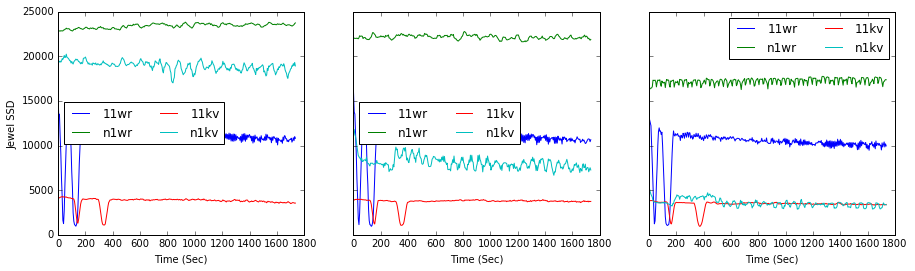

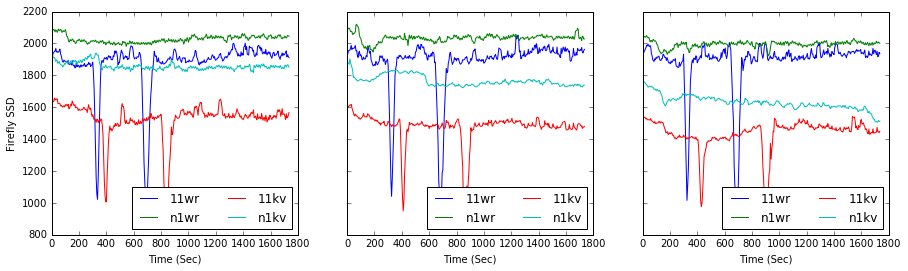

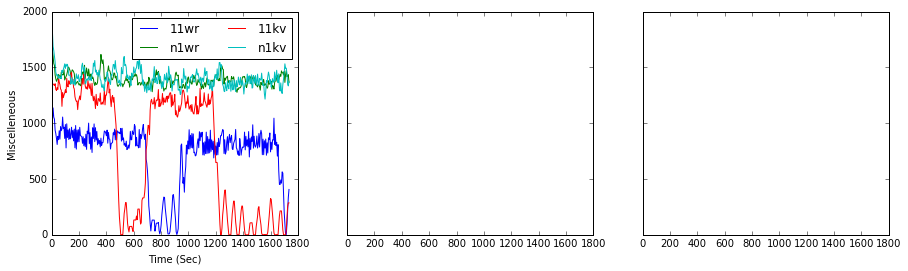

In [107]:
plt.rcParams['figure.figsize'] = 15,4

f1, axs1 = plt.subplots(1, 3, sharex=True, sharey=True)
plot_sub_sweep(axs1[0], 'jewel', 'write', 'ssd', 'small')
plot_sub_sweep(axs1[1], 'jewel', 'write', 'ssd', 'med')
plot_sub_sweep(axs1[2], 'jewel', 'write', 'ssd', 'large')
axs1[0].set_ylabel('Jewel SSD')

f2, axs2 = plt.subplots(1, 3, sharex=True, sharey=True)
plot_sub_sweep(axs2[0], 'firefly', 'write', 'ssd', 'small')
plot_sub_sweep(axs2[1], 'firefly', 'write', 'ssd', 'med')
plot_sub_sweep(axs2[2], 'firefly', 'write', 'ssd', 'large')
axs2[0].set_ylabel('Firefly SSD')

f3, axs3 = plt.subplots(1, 3, sharex=True, sharey=True)
plot_sub_sweep(axs3[0], 'jewel', 'write', 'hdd', 'small')
axs3[0].set_ylabel('Miscelleneous')

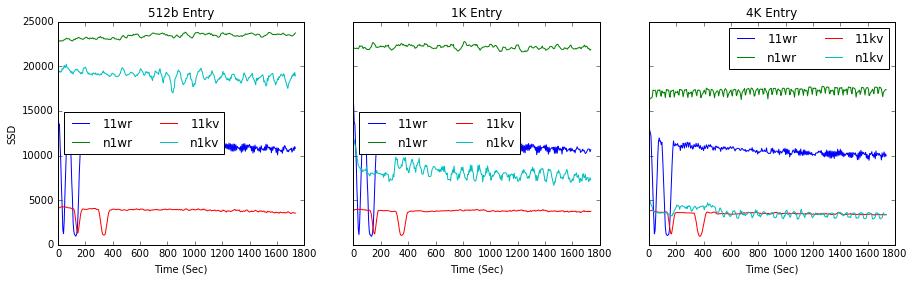

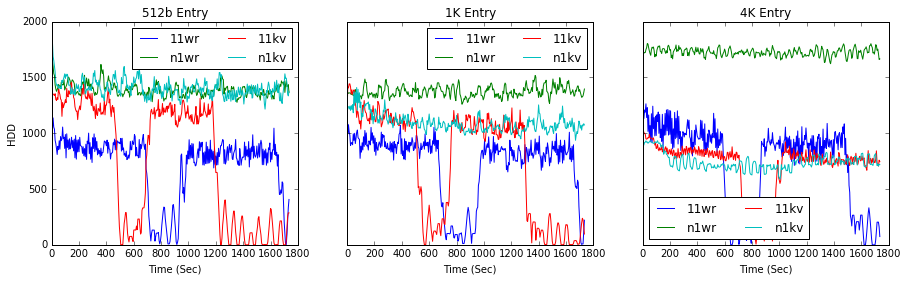

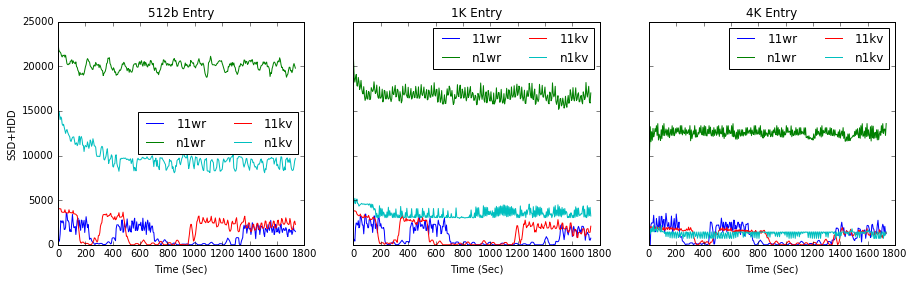

In [94]:
plot_sweep('jewel', 'write')

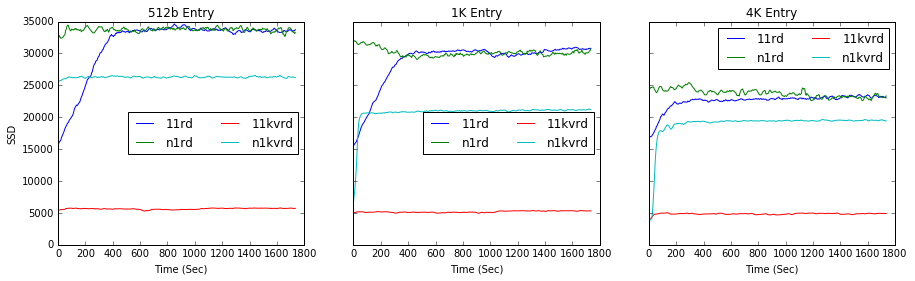

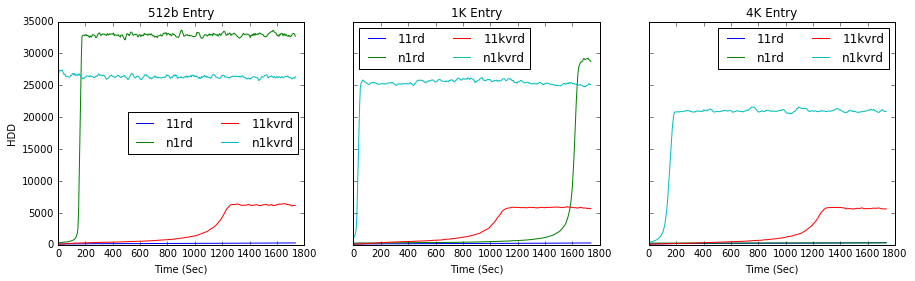

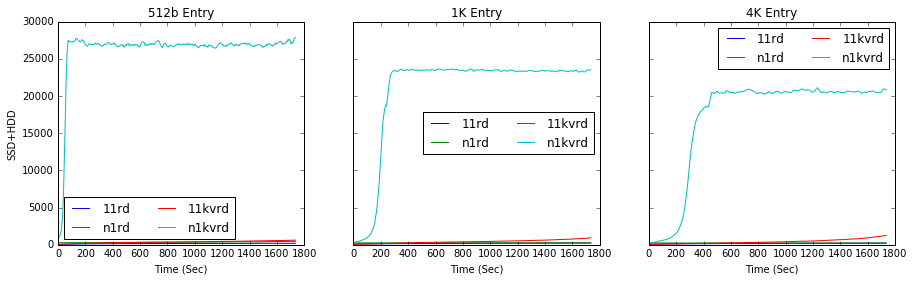

In [95]:
plot_sweep('jewel', 'read')

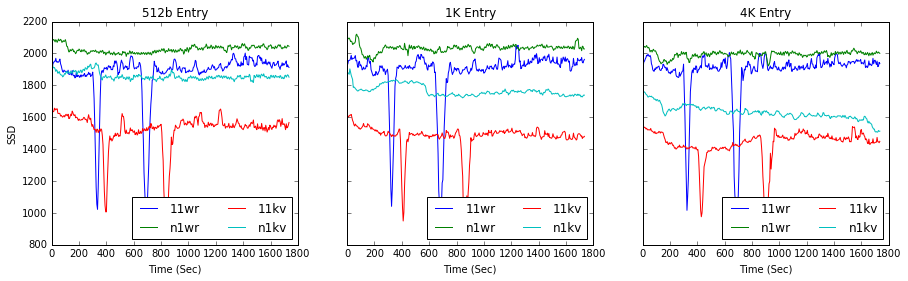

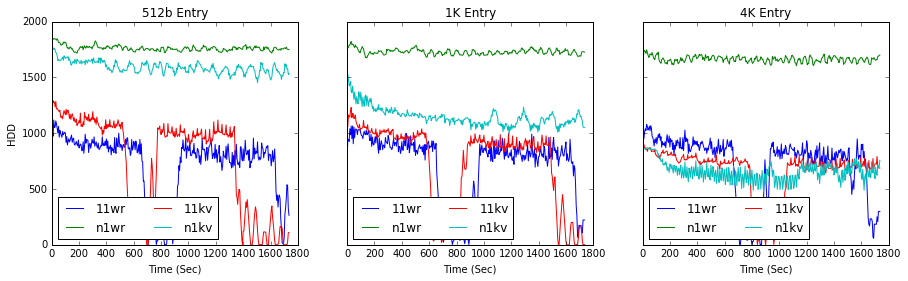

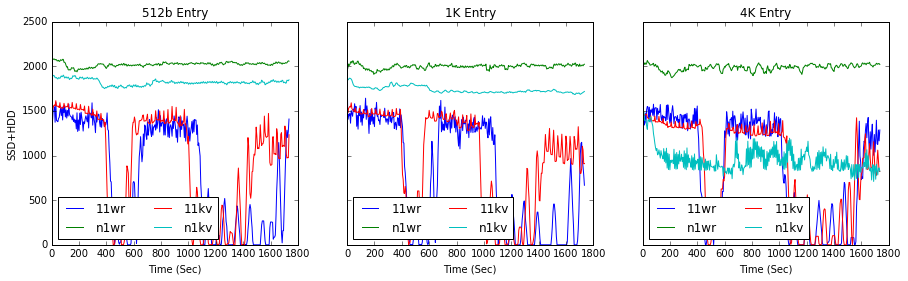

In [96]:
plot_sweep('firefly', 'write')

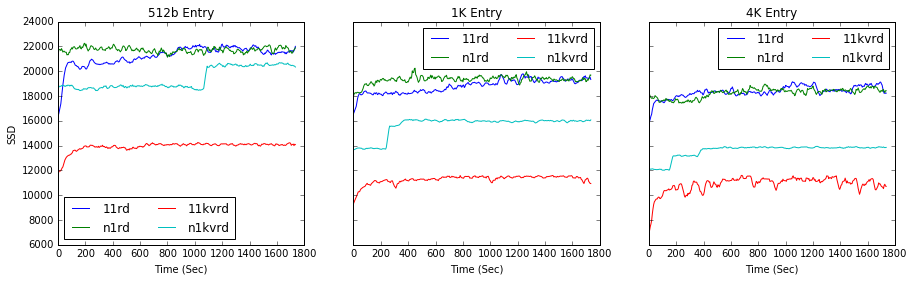

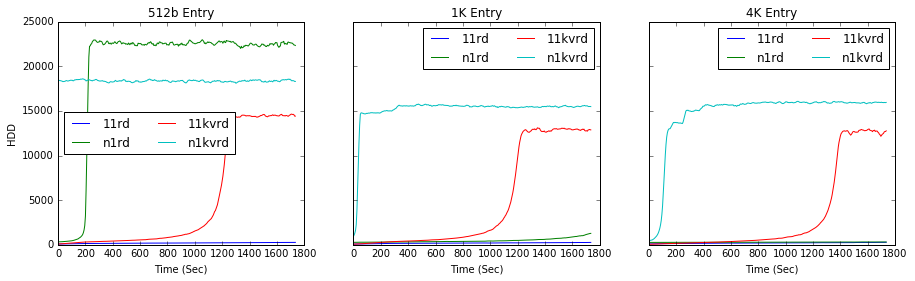

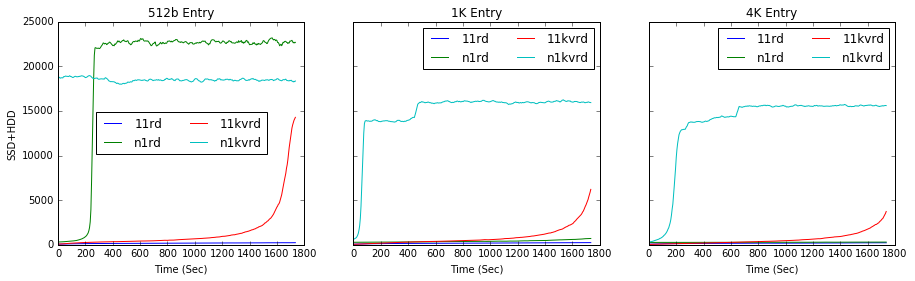

In [97]:
plot_sweep('firefly', 'read')

In [98]:
def cherry_pick(ax, ver, iodir, conf, esize, ignore):
    dirfilter = '*librados_%s_%s_%s.node0*/*.log' % (ver, conf, esize)
    allfiles = glob.glob(dirfilter)
    readfiles = filter(lambda fn: '_read_' in fn, allfiles)
    if iodir == 'read':
        traces = readfiles
    else:
        traces = [fn for fn in allfiles if fn not in readfiles]
    traces = filter(lambda fn: ignore not in fn, traces)
    plot_traces(list(traces), 'a', finish=False, useAx=ax)
    lgd = ax.legend(loc='best', ncol=2)#, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
    #plt.savefig('%s_reads.png' % name, dpi=300, bbox_inches='tight') 

# WRITES

(0, 3000)

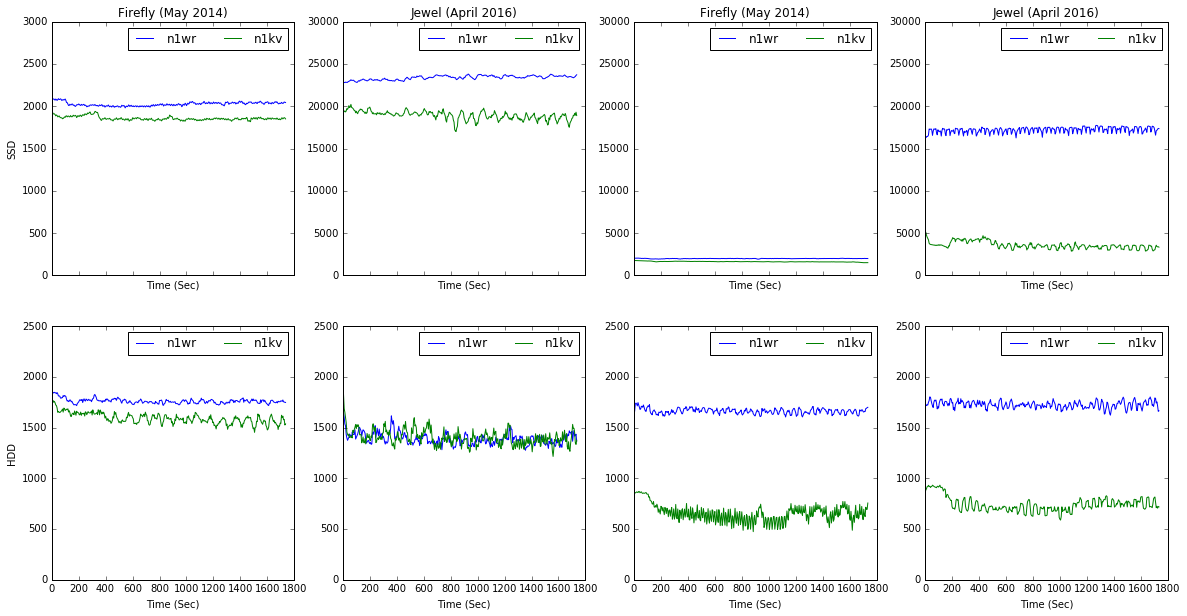

In [99]:
plt.rcParams['figure.figsize'] = 20, 10

nsubplots = 4
f, axs = plt.subplots(2,4, sharex=True)

cherry_pick(axs[0,0], 'firefly', 'write', 'ssd', 'small', '_11_')
cherry_pick(axs[1,0], 'firefly', 'write', 'hdd', 'small', '_11_')
cherry_pick(axs[0,1], 'jewel', 'write', 'ssd', 'small', '_11_')
cherry_pick(axs[1,1], 'jewel', 'write', 'hdd', 'small', '_11_')
cherry_pick(axs[0,2], 'firefly', 'write', 'ssd', 'large', '_11_')
cherry_pick(axs[1,2], 'firefly', 'write', 'hdd', 'large', '_11_')
cherry_pick(axs[0,3], 'jewel', 'write', 'ssd', 'large', '_11_')
cherry_pick(axs[1,3], 'jewel', 'write', 'hdd', 'large', '_11_')


axs[0,0].set_ylabel('SSD')
axs[1,0].set_ylabel('HDD')
axs[0,0].set_title('Firefly (May 2014)')
axs[0,1].set_title('Jewel (April 2016)')
axs[0,2].set_title('Firefly (May 2014)')
axs[0,3].set_title('Jewel (April 2016)')

for i in range(0, nsubplots):
    axs[0, i].set_ylim(0, 30000)
for i in range(0, nsubplots):
    axs[1, i].set_ylim(0, 2500)
axs[0, 0].set_ylim(0, 3000)

,lat,pct
0,4,1
1,5,2
2,6,3


n1wr 128b 23391.0314176
n1kv 128b 18939.3763889
n1wr 4KB 17209.6930556
n1kv 4KB 3581.61029693
n1wr 128b 1392.45622605
n1kv 128b 1403.71216475
n1wr 4KB 1726.4743295
n1kv 4KB 743.600670498
n1wr 128b 2026.98611111
n1kv 128b 1858.72485632
n1wr 4KB 1995.97413793
n1kv 4KB 1630.43347701
n1wr 128b 1761.95689655
n1kv 128b 1592.65603448
n1wr 4KB 1663.72538314
n1kv 4KB 656.581657088


(0, 3000)

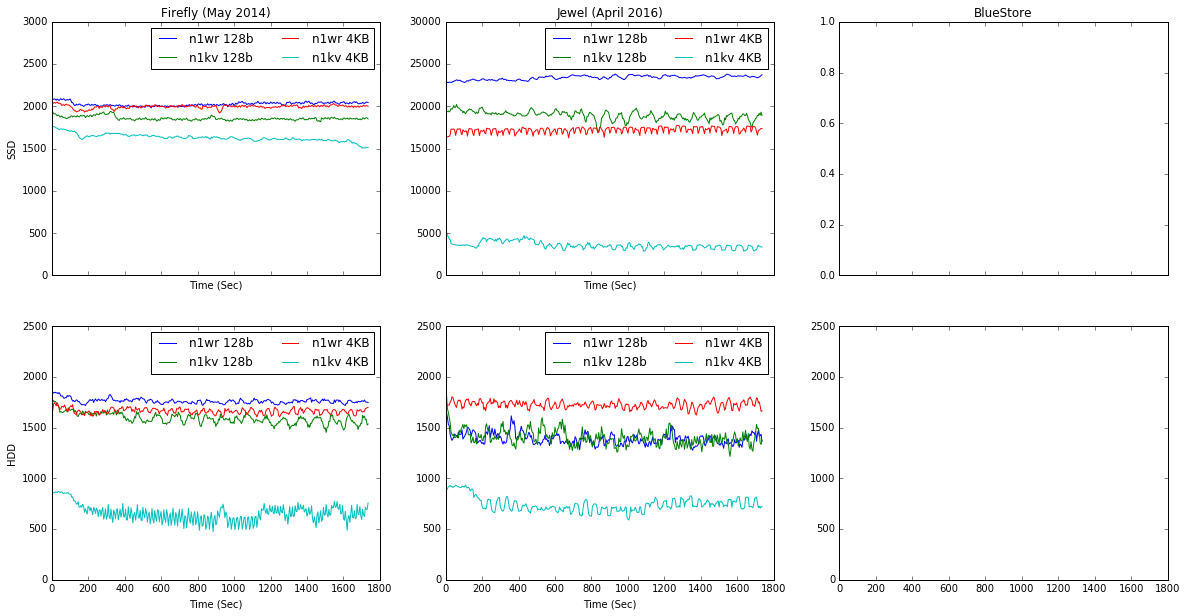

In [96]:
plt.rcParams['figure.figsize'] = 20, 10

nsubplots = 3
f, axs = plt.subplots(2,3, sharex=True)
cherry_pick(axs[0,1], 'jewel', 'write', 'ssd', 'small', '_11_')
cherry_pick(axs[0,1], 'jewel', 'write', 'ssd', 'large', '_11_')
cherry_pick(axs[1,1], 'jewel', 'write', 'hdd', 'small', '_11_')
cherry_pick(axs[1,1], 'jewel', 'write', 'hdd', 'large', '_11_')

cherry_pick(axs[0,0], 'firefly', 'write', 'ssd', 'small', '_11_')
cherry_pick(axs[0,0], 'firefly', 'write', 'ssd', 'large', '_11_')
cherry_pick(axs[1,0], 'firefly', 'write', 'hdd', 'small', '_11_')
cherry_pick(axs[1,0], 'firefly', 'write', 'hdd', 'large', '_11_')

axs[0,0].set_ylabel('SSD')
axs[1,0].set_ylabel('HDD')
axs[0,0].set_title('Firefly (May 2014)')
axs[0,1].set_title('Jewel (April 2016)')
axs[0,2].set_title('BlueStore')

for i in range(0, nsubplots):
    axs[0, 1].set_ylim(0, 30000)
for i in range(0, nsubplots):
    axs[1, i].set_ylim(0, 2500)
axs[0, 0].set_ylim(0, 3000)

# READS

n1rd 128b 33726.1672414
n1kvrd 128b 26288.9187261
n1rd 4KB 23782.4748563
n1kvrd 4KB 18906.6785441
n1rd 128b 29915.3524904
n1kvrd 128b 26369.0385536
n1rd 4KB 287.104837165
n1kvrd 4KB 19274.7198276
n1rd 128b 21719.8887452
n1kvrd 128b 19394.7311303
n1rd 4KB 18251.9663314
n1kvrd 4KB 13587.267864
n1rd 128b 19838.4935824
n1kvrd 128b 18353.7246169
n1rd 4KB 293.316091954
n1kvrd 4KB 14632.1614943


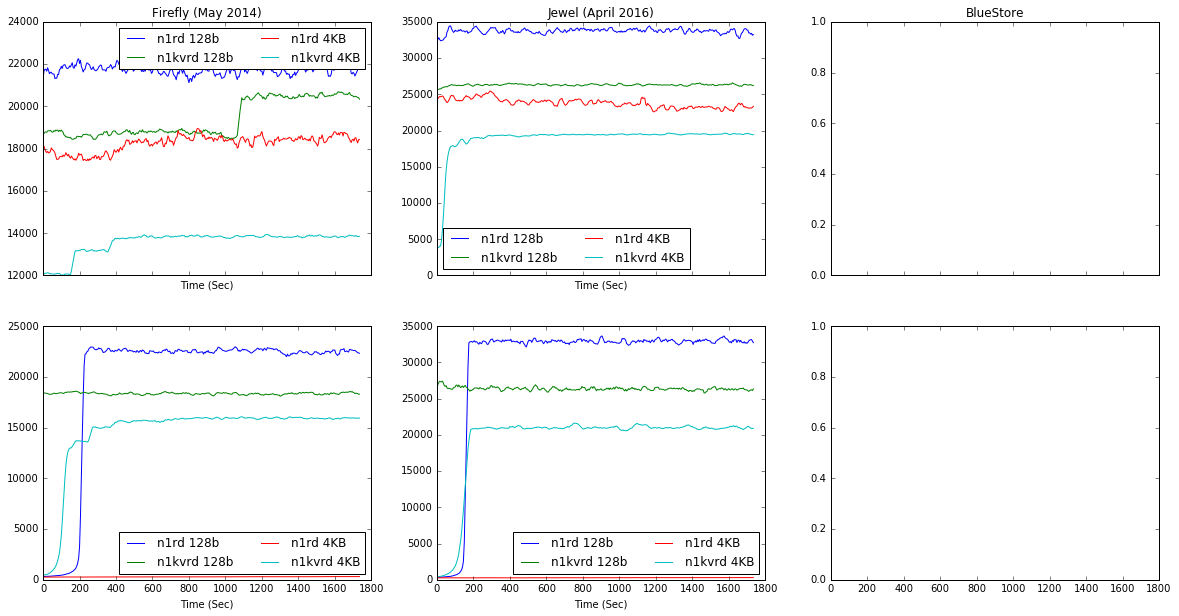

In [64]:
plt.rcParams['figure.figsize'] = 20, 10

nsubplots = 3
f, axs = plt.subplots(2,3, sharex=True)
cherry_pick(axs[0,1], 'jewel', 'read', 'ssd', 'small', '_11_')
cherry_pick(axs[0,1], 'jewel', 'read', 'ssd', 'large', '_11_')
cherry_pick(axs[1,1], 'jewel', 'read', 'hdd', 'small', '_11_')
cherry_pick(axs[1,1], 'jewel', 'read', 'hdd', 'large', '_11_')

cherry_pick(axs[0,0], 'firefly', 'read', 'ssd', 'small', '_11_')
cherry_pick(axs[0,0], 'firefly', 'read', 'ssd', 'large', '_11_')
cherry_pick(axs[1,0], 'firefly', 'read', 'hdd', 'small', '_11_')
cherry_pick(axs[1,0], 'firefly', 'read', 'hdd', 'large', '_11_')

#cherry_pick_bluestore(axs[0,0], '', '', '', '', '')

#axs[0,0].set_ylabel('SSD')
#axs[1,0].set_ylabel('HDD')
axs[0,0].set_title('Firefly (May 2014)')
axs[0,1].set_title('Jewel (April 2016)')
axs[0,2].set_title('BlueStore')

#for i in range(0, nsubplots):
#    axs[0, 1].set_ylim(0, 30000)
#for i in range(0, nsubplots):
#    axs[1, i].set_ylim(0, 35000)

<Container object of 1 artists>

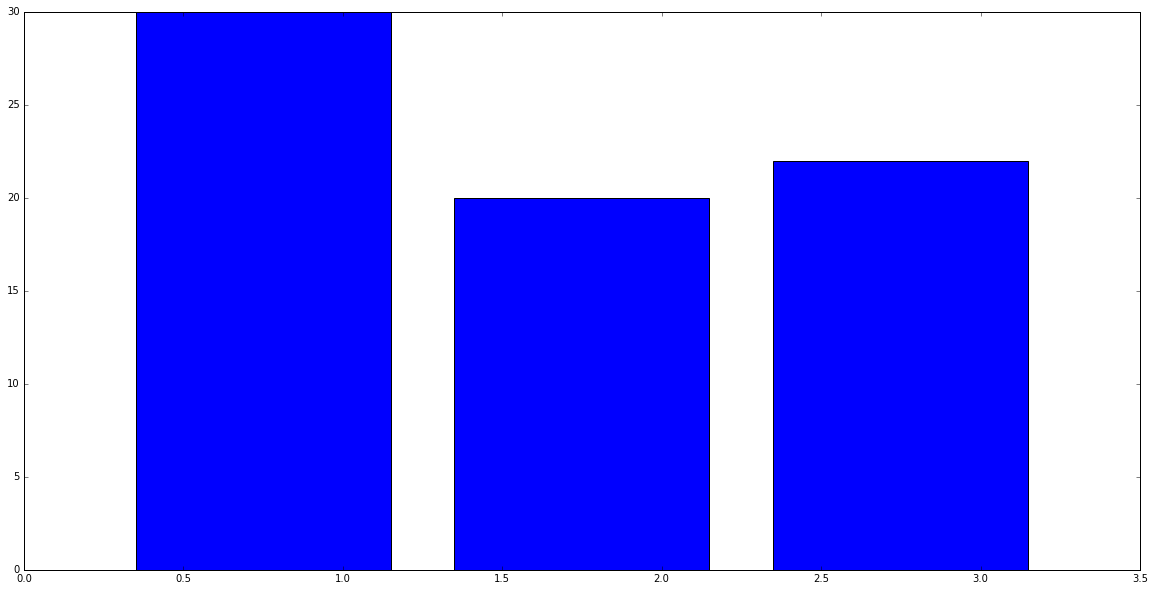

In [103]:
fig, ax = plt.subplots()
ax.bar(0 + .35, [30])
ax.bar(1 + .35, [20])
ax.bar(2 + .35, [22])

In [115]:
percents = [1, 2, 3]
latencies = [4, 5, 6]
df = pd.DataFrame({'pct': percents, 'lat': latencies})
df['x'] = 3




,lat,pct,x
0,4,1,3
1,5,2,3
2,6,3,3
